# House Prices - Advanced Regression Techniques

You have some experience with R or Python and machine learning basics. This is a perfect competition for data science students who have completed an online course in machine learning and are looking to expand their skill set before trying a featured competition. 

## Competition Description

![](https://kaggle2.blob.core.windows.net/competitions/kaggle/5407/media/housesbanner.png)

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

## Practice Skills
* Creative feature engineering 
* Advanced regression techniques like random forest and gradient boosting



In [64]:
import urllib
import zipfile
import os

if not os.path.exists('./data'):
    os.mkdir('./data')

zipfile.ZipFile('all.zip').extractall("./data")

In [65]:
import pandas as pd
import numpy as np

train = pd.read_csv('./data/train.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [66]:
categorical = [
    'MSSubClass',
    'MSZoning',
    'Street',
    'Alley',
    'LotShape',
    'LandContour',
    'Utilities',
    'LotConfig',
    'LandSlope',
    'Neighborhood',
    'Condition1',
    'Condition2',
    'BldgType',
    'HouseStyle',
    'RoofStyle',
    'RoofMatl',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'ExterQual',
    'ExterCond',
    'Foundation',
    'BsmtQual',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'Heating',
    'HeatingQC',
    'CentralAir',
    'Electrical',
    'KitchenQual',
    'Functional',
    'FireplaceQu',
    'GarageType',
    'GarageFinish',
    'GarageQual',
    'GarageCond',
    'PavedDrive',
    'PoolQC',
    'Fence',
    'MiscFeature',
    'SaleType',
    'SaleCondition'
]

train[categorical] = train[categorical].astype("category")

train.dtypes

# train.describe()

Id                  int64
MSSubClass       category
MSZoning         category
LotFrontage       float64
LotArea             int64
Street           category
Alley            category
LotShape         category
LandContour      category
Utilities        category
LotConfig        category
LandSlope        category
Neighborhood     category
Condition1       category
Condition2       category
BldgType         category
HouseStyle       category
OverallQual         int64
OverallCond         int64
YearBuilt           int64
YearRemodAdd        int64
RoofStyle        category
RoofMatl         category
Exterior1st      category
Exterior2nd      category
MasVnrType       category
MasVnrArea        float64
ExterQual        category
ExterCond        category
Foundation       category
                   ...   
BedroomAbvGr        int64
KitchenAbvGr        int64
KitchenQual      category
TotRmsAbvGrd        int64
Functional       category
Fireplaces          int64
FireplaceQu      category
GarageType  

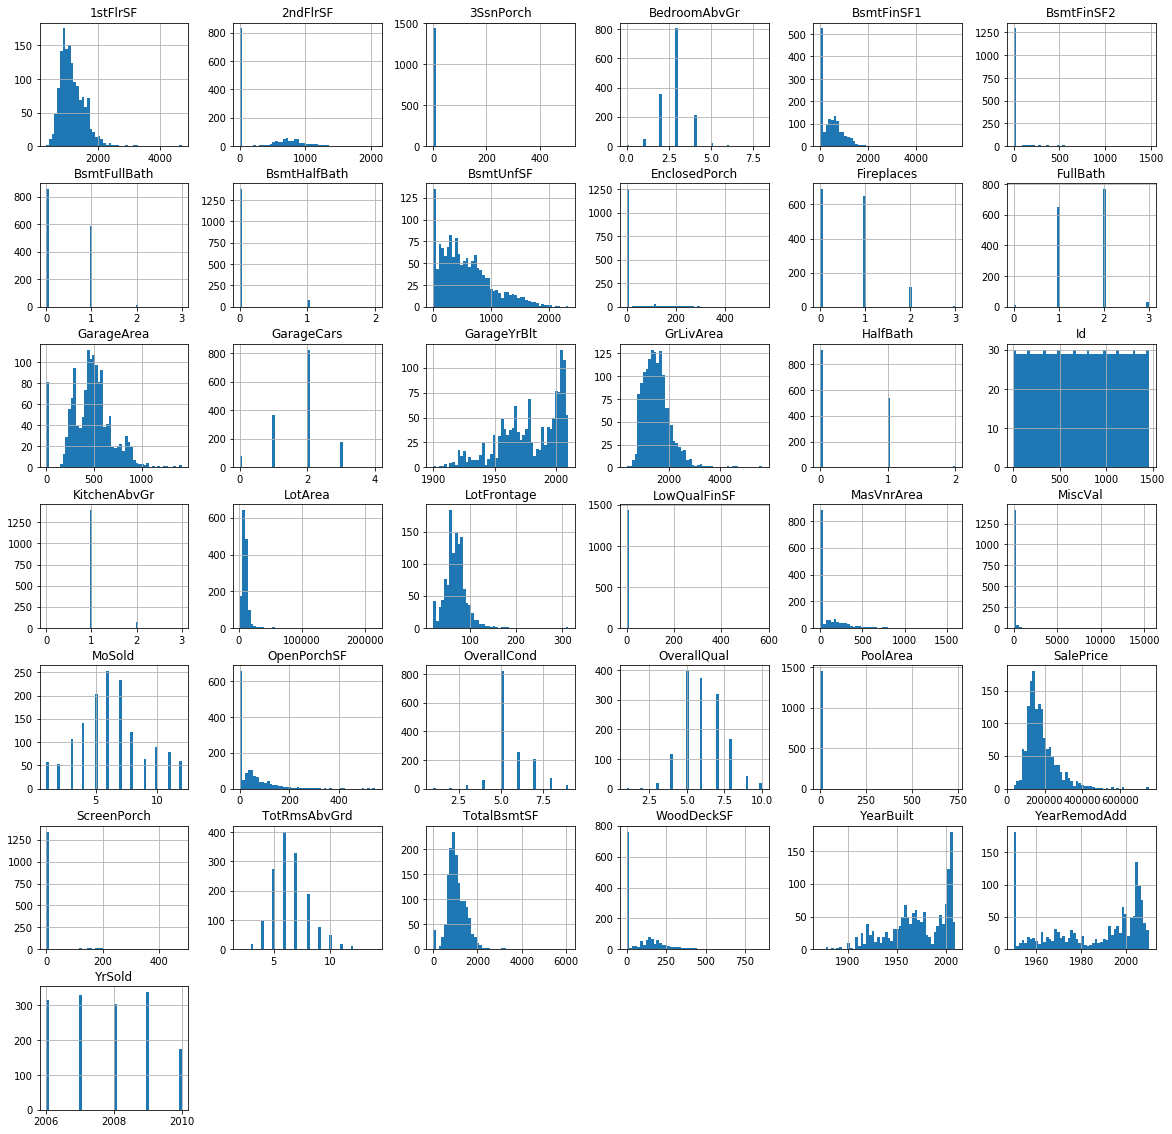

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt
train.hist(bins=50, figsize=(20,20))
plt.show()

In [68]:
corr_matrix = train.corr()
top_corr = corr_matrix["SalePrice"].sort_values(ascending=False)
top_corr

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

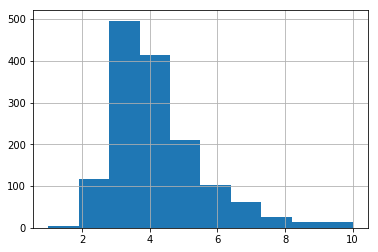

In [69]:
train['SaleBin'] = np.ceil(train['SalePrice']/50000)
train['SaleBin'].where(train['SaleBin'] < 10, 10, inplace=True)
train['SaleBin'].hist()

In [70]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in split.split(train, train['SaleBin']):
    train_set = train.loc[train_idx]
    test_set = train.loc[test_idx]
    
print(train_set.shape)
print(test_set.shape)

(1168, 82)
(292, 82)


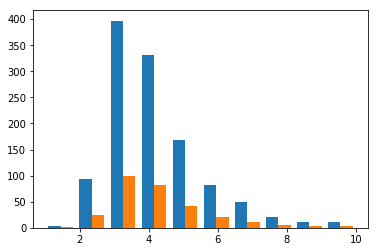

In [71]:
# check distribution of train and test set

fig = plt.figure()
ax = fig.add_subplot(111)
_ = ax.hist([train_set['SaleBin'].values, test_set['SaleBin'].values])

In [72]:
# drop columns with some undefined data
features = train.columns[train.notna().all()].values
features = features[~np.in1d(features, ["Id", "SalePrice", "SaleBin"])]
cat = np.intersect1d(features, np.array(categorical))
non_cat = np.setdiff1d(features, np.array(categorical))
features

array(['MSSubClass', 'MSZoning', 'LotArea', 'Street', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageCars',
       'GarageArea', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SaleType', 'SaleCondition'], dtype=object)

In [90]:
# standardize features
train[categorical]

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([
        ("num", StandardScaler(), non_cat),
        ("cat", OneHotEncoder(), cat),
    ])

full_pipeline.fit(train[features])

train_trans = full_pipeline.transform(train_set[features])
test_trans = full_pipeline.transform(test_set[features])

assert train_trans.shape[1] == test_trans.shape[1]

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)


In [103]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

train_labels = train_set['SalePrice']

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=100, cv=5, scoring='neg_mean_squared_error', random_state=42, verbose=10)
rnd_search.fit(train_trans, train_labels)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] max_features=7, n_estimators=180 ................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_features=7, n_estimators=180, score=-1617505112.44117, total=   0.9s
[CV] max_features=7, n_estimators=180 ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV]  max_features=7, n_estimators=180, score=-1154947022.4696262, total=   0.9s
[CV] max_features=7, n_estimators=180 ................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s


[CV]  max_features=7, n_estimators=180, score=-1028398131.0181409, total=   0.9s
[CV] max_features=7, n_estimators=180 ................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.9s remaining:    0.0s


[CV]  max_features=7, n_estimators=180, score=-854903723.2406716, total=   0.9s
[CV] max_features=7, n_estimators=180 ................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.8s remaining:    0.0s


[CV]  max_features=7, n_estimators=180, score=-1026414349.0719916, total=   0.9s
[CV] max_features=5, n_estimators=15 .................................
[CV]  max_features=5, n_estimators=15, score=-1486105586.914207, total=   0.1s
[CV] max_features=5, n_estimators=15 .................................
[CV]  max_features=5, n_estimators=15, score=-1352104523.3018045, total=   0.1s
[CV] max_features=5, n_estimators=15 .................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    5.0s remaining:    0.0s


[CV]  max_features=5, n_estimators=15, score=-1250899178.3004177, total=   0.1s
[CV] max_features=5, n_estimators=15 .................................
[CV]  max_features=5, n_estimators=15, score=-982433227.2986362, total=   0.1s
[CV] max_features=5, n_estimators=15 .................................
[CV]  max_features=5, n_estimators=15, score=-1235336252.6082022, total=   0.1s
[CV] max_features=3, n_estimators=72 .................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    5.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    5.1s remaining:    0.0s


[CV]  max_features=3, n_estimators=72, score=-1926143201.0790646, total=   0.3s
[CV] max_features=3, n_estimators=72 .................................
[CV]  max_features=3, n_estimators=72, score=-1439563687.9294524, total=   0.3s
[CV] max_features=3, n_estimators=72 .................................
[CV]  max_features=3, n_estimators=72, score=-1214989022.059143, total=   0.3s
[CV] max_features=3, n_estimators=72 .................................
[CV]  max_features=3, n_estimators=72, score=-963030570.371425, total=   0.3s
[CV] max_features=3, n_estimators=72 .................................
[CV]  max_features=3, n_estimators=72, score=-1062209965.0488801, total=   0.3s
[CV] max_features=5, n_estimators=21 .................................
[CV]  max_features=5, n_estimators=21, score=-1655083596.4840689, total=   0.1s
[CV] max_features=5, n_estimators=21 .................................
[CV]  max_features=5, n_estimators=21, score=-1374889980.5299149, total=   0.1s
[CV] max_features

[CV]  max_features=1, n_estimators=58, score=-2082908763.8093417, total=   0.3s
[CV] max_features=1, n_estimators=58 .................................
[CV]  max_features=1, n_estimators=58, score=-1712724905.9432428, total=   0.3s
[CV] max_features=1, n_estimators=58 .................................
[CV]  max_features=1, n_estimators=58, score=-1479206686.947618, total=   0.2s
[CV] max_features=1, n_estimators=58 .................................
[CV]  max_features=1, n_estimators=58, score=-1105660306.3674936, total=   0.2s
[CV] max_features=1, n_estimators=58 .................................
[CV]  max_features=1, n_estimators=58, score=-1122598372.0962474, total=   0.2s
[CV] max_features=6, n_estimators=89 .................................
[CV]  max_features=6, n_estimators=89, score=-1746908790.5534286, total=   0.4s
[CV] max_features=6, n_estimators=89 .................................
[CV]  max_features=6, n_estimators=89, score=-1154546730.1313925, total=   0.5s
[CV] max_featur

[CV]  max_features=5, n_estimators=51, score=-1601236292.7013853, total=   0.2s
[CV] max_features=5, n_estimators=51 .................................
[CV]  max_features=5, n_estimators=51, score=-1279457579.9214814, total=   0.2s
[CV] max_features=5, n_estimators=51 .................................
[CV]  max_features=5, n_estimators=51, score=-1263246096.679436, total=   0.2s
[CV] max_features=5, n_estimators=51 .................................
[CV]  max_features=5, n_estimators=51, score=-939868996.0322639, total=   0.2s
[CV] max_features=5, n_estimators=51 .................................
[CV]  max_features=5, n_estimators=51, score=-1102055918.9434981, total=   0.2s
[CV] max_features=7, n_estimators=21 .................................
[CV]  max_features=7, n_estimators=21, score=-1657006092.7471268, total=   0.1s
[CV] max_features=7, n_estimators=21 .................................
[CV]  max_features=7, n_estimators=21, score=-1076783973.9460723, total=   0.1s
[CV] max_feature

[CV]  max_features=7, n_estimators=35, score=-1126891674.1908774, total=   0.2s
[CV] max_features=7, n_estimators=35 .................................
[CV]  max_features=7, n_estimators=35, score=-950200541.5303749, total=   0.2s
[CV] max_features=7, n_estimators=35 .................................
[CV]  max_features=7, n_estimators=35, score=-855305897.7063187, total=   0.2s
[CV] max_features=7, n_estimators=35 .................................
[CV]  max_features=7, n_estimators=35, score=-1026533855.1165036, total=   0.2s
[CV] max_features=6, n_estimators=81 .................................
[CV]  max_features=6, n_estimators=81, score=-1753326073.1334252, total=   0.4s
[CV] max_features=6, n_estimators=81 .................................
[CV]  max_features=6, n_estimators=81, score=-1135798085.7334669, total=   0.4s
[CV] max_features=6, n_estimators=81 .................................
[CV]  max_features=6, n_estimators=81, score=-1123734141.3726323, total=   0.4s
[CV] max_feature

[CV]  max_features=7, n_estimators=48, score=-1167318843.7292652, total=   0.3s
[CV] max_features=7, n_estimators=48 .................................
[CV]  max_features=7, n_estimators=48, score=-992271420.9047811, total=   0.3s
[CV] max_features=7, n_estimators=48 .................................
[CV]  max_features=7, n_estimators=48, score=-859044988.8931974, total=   0.2s
[CV] max_features=7, n_estimators=48 .................................
[CV]  max_features=7, n_estimators=48, score=-1001799438.9851295, total=   0.3s
[CV] max_features=7, n_estimators=190 ................................
[CV]  max_features=7, n_estimators=190, score=-1595318628.1752002, total=   1.0s
[CV] max_features=7, n_estimators=190 ................................
[CV]  max_features=7, n_estimators=190, score=-1165059370.0700147, total=   1.0s
[CV] max_features=7, n_estimators=190 ................................
[CV]  max_features=7, n_estimators=190, score=-1024870415.1784891, total=   1.0s
[CV] max_feat

[CV]  max_features=7, n_estimators=139, score=-1128789147.9907732, total=   0.7s
[CV] max_features=7, n_estimators=139 ................................
[CV]  max_features=7, n_estimators=139, score=-994381938.7014301, total=   0.8s
[CV] max_features=7, n_estimators=139 ................................
[CV]  max_features=7, n_estimators=139, score=-844864243.5838395, total=   0.7s
[CV] max_features=7, n_estimators=139 ................................
[CV]  max_features=7, n_estimators=139, score=-1034795387.8076471, total=   0.8s
[CV] max_features=3, n_estimators=81 .................................
[CV]  max_features=3, n_estimators=81, score=-1909156266.6007462, total=   0.4s
[CV] max_features=3, n_estimators=81 .................................
[CV]  max_features=3, n_estimators=81, score=-1410807944.3381572, total=   0.4s
[CV] max_features=3, n_estimators=81 .................................
[CV]  max_features=3, n_estimators=81, score=-1230247752.2494376, total=   0.4s
[CV] max_fea

[CV]  max_features=3, n_estimators=172, score=-1375800140.812101, total=   0.7s
[CV] max_features=3, n_estimators=172 ................................
[CV]  max_features=3, n_estimators=172, score=-1228575810.5739007, total=   0.7s
[CV] max_features=3, n_estimators=172 ................................
[CV]  max_features=3, n_estimators=172, score=-938950222.4530027, total=   0.9s
[CV] max_features=3, n_estimators=172 ................................
[CV]  max_features=3, n_estimators=172, score=-1058250750.1604549, total=   0.7s
[CV] max_features=6, n_estimators=35 .................................
[CV]  max_features=6, n_estimators=35, score=-1801621725.349618, total=   0.2s
[CV] max_features=6, n_estimators=35 .................................
[CV]  max_features=6, n_estimators=35, score=-1075387495.6859164, total=   0.2s
[CV] max_features=6, n_estimators=35 .................................
[CV]  max_features=6, n_estimators=35, score=-1185303328.1103125, total=   0.2s
[CV] max_feat

[CV]  max_features=7, n_estimators=52, score=-1186324059.2090902, total=   0.3s
[CV] max_features=7, n_estimators=52 .................................
[CV]  max_features=7, n_estimators=52, score=-967821254.630508, total=   0.3s
[CV] max_features=7, n_estimators=52 .................................
[CV]  max_features=7, n_estimators=52, score=-871519955.42891, total=   0.3s
[CV] max_features=7, n_estimators=52 .................................
[CV]  max_features=7, n_estimators=52, score=-1005754708.1959358, total=   0.3s
[CV] max_features=5, n_estimators=96 .................................
[CV]  max_features=5, n_estimators=96, score=-1708425009.412315, total=   0.5s
[CV] max_features=5, n_estimators=96 .................................
[CV]  max_features=5, n_estimators=96, score=-1237627620.63906, total=   0.5s
[CV] max_features=5, n_estimators=96 .................................
[CV]  max_features=5, n_estimators=96, score=-1169384823.8446288, total=   0.4s
[CV] max_features=5, n

[CV]  max_features=5, n_estimators=134, score=-1226037506.124532, total=   0.6s
[CV] max_features=5, n_estimators=134 ................................
[CV]  max_features=5, n_estimators=134, score=-1110729281.0496418, total=   0.6s
[CV] max_features=5, n_estimators=134 ................................
[CV]  max_features=5, n_estimators=134, score=-908566669.90645, total=   0.7s
[CV] max_features=5, n_estimators=134 ................................
[CV]  max_features=5, n_estimators=134, score=-1010730058.8050445, total=   0.6s
[CV] max_features=4, n_estimators=28 .................................
[CV]  max_features=4, n_estimators=28, score=-1714215985.4427054, total=   0.1s
[CV] max_features=4, n_estimators=28 .................................
[CV]  max_features=4, n_estimators=28, score=-1394301624.6416035, total=   0.1s
[CV] max_features=4, n_estimators=28 .................................
[CV]  max_features=4, n_estimators=28, score=-1057746785.8162503, total=   0.1s
[CV] max_featu

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  3.7min finished
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=None,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9ac25cb940>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9ac25cbcc0>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=10)

In [110]:
predictor = rnd_search.best_estimator_

In [116]:
from sklearn.metrics import mean_squared_log_error
from math import sqrt

test_labels = test_set['SalePrice']

predictions = predictor.predict(test_trans)

print(sqrt(mean_squared_log_error(test_labels, predictions)))

0.16928116991178796
